# Wasserstein GAN (WGAN) by `Mr. Harshit Dawar!`
* Addresses the following problems of DCGANs
    * Mode Collapse
    * Vanishing Gradient
* It also requires less epochs to provide better results as compared to the DCGANs
* It takes more time to train as compared to DCGANs

In [1]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers as ly
import tensorflow as tf
import os
import time
from IPython import display

## Downloading the Fashion MNIST Dataset, processing it, & visualizing it

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

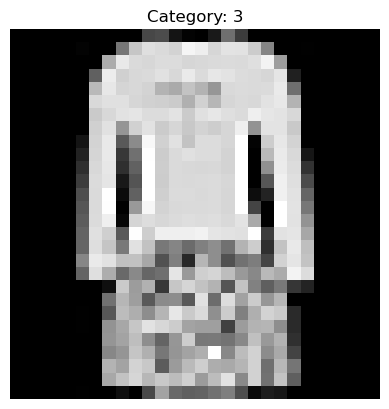

In [4]:
random_image = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[random_image], cmap = "gray")
plt.title("Category: " + str(y_train[random_image]))
plt.axis("off")
plt.show()

In [5]:
# Generating the 3rd Dimenstion for the image as per the requirement of the task
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [6]:
# Normalizing the images between -1 to 1
X_train = (X_train - 127.5) / 127.5

In [7]:
X_train.min(), X_train.max()

(-1.0, 1.0)

In [8]:
batch_size = 64
total_images = X_train.shape[0]
total_number_of_batches = total_images / batch_size

In [9]:
total_number_of_batches

937.5

In [10]:
X_train[0].dtype

dtype('float32')

In [11]:
# Changing the type of X_train from numpy array to tensorflow batchdataset
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(total_images).batch(batch_size)

In [12]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

## Creating the Generator for the WGAN
* It is same as DCGANs

In [17]:
def generator_builder():
    model = tf.keras.Sequential()
    
    # For the Random Noise/Image of a vector shape of 100 
    model.add(ly.Dense(units = 7 * 7 * 256, use_bias = False, input_shape = (100, )))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # To Reshape the above flattened vector
    model.add(ly.Reshape((7, 7, 256)))
    
    # Conv2DTranspose Block 1 for generating a bigger image : Image size is 7x7x256
    model.add(ly.Conv2DTranspose(filters = 256, kernel_size = (3, 3), padding = "same", use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # Conv2DTranspose Block 2 for generating a bigger image : Image size is 14x14x64
    model.add(ly.Conv2DTranspose(filters = 64, kernel_size = (3, 3), padding = "same", strides = (2, 2), use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    # Conv2DTranspose Block 3 for generating a bigger image : Image size is 28x28x1
    model.add(ly.Conv2DTranspose(filters = 1, kernel_size = (3, 3), padding = "same", strides = (2, 2), use_bias = True, activation = "tanh"))
    
    model.summary()
    return model

In [18]:
# Defining a generator
generator = generator_builder()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_6 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 256)        589824    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 256)       

In [19]:
random_noise = tf.random.normal([1, 100])
random_noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.44256973, -1.417305  , -0.12087763, -0.8255383 ,  1.4733219 ,
        -0.03573745,  0.05656287, -0.68998   ,  1.1807369 ,  0.45201555,
         1.938813  ,  1.0468434 ,  0.7665597 ,  0.31601104, -1.0328954 ,
         0.3339553 ,  2.1407585 , -3.0317893 , -0.02570817,  0.86685544,
        -0.85074234,  0.25373057, -0.6900784 , -0.21215507,  0.71538836,
         2.3438647 ,  1.4779005 ,  0.9065585 ,  0.77689207,  1.3629977 ,
         1.6282281 ,  0.07584841,  1.7804182 ,  1.1475476 ,  0.6730785 ,
         0.9188278 , -0.87963   ,  0.20840287, -0.5806772 ,  0.22099124,
         0.5596699 ,  0.24579237,  0.14380522, -2.286408  , -0.02999567,
        -0.31157914, -0.63642526, -0.48491377,  0.64081275, -0.35369644,
        -0.5675317 ,  1.196602  , -1.15186   ,  0.5807919 ,  1.3920268 ,
         1.1019497 , -0.51390994, -1.401124  ,  1.9662247 ,  0.7533127 ,
         0.9134926 , -0.5820843 , -0.22057028,  2.0670514 , -2.3154678 ,
 

In [20]:
random_image_generated_from_generator = generator(random_noise, training = False)

In [21]:
random_image_generated_from_generator.shape

TensorShape([1, 28, 28, 1])

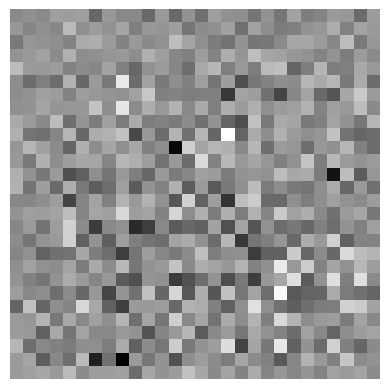

In [22]:
plt.imshow(random_image_generated_from_generator[0], cmap = "gray")
plt.axis("off")
plt.show()